# What's this notebook for?

It is important to specify your models to cvxpy in the most efficient way possible. This means that you should do your best to use the minimum number of cvxpy Constraint and Variable objects necessary to specify your model. For example, if you needed to write the constraint "Ax = b", it is grealy preferred that you do this by "A * x == b", rather than "a_i * x == b_i" for every row a_i of A and every entry b_i of b.

This notebook provides explicit demonstrations of how you can expect compile time for cvxpy to vary based on how you specify your model.

# Introduction

Throughout this notebook, we will consider the problem

P(A,b,c) = min{ c.T * x  :  A x = b, 0 <= x <= 1}

where A is an m-by-n matrix. Note that this is really the best-case scenario for cvxpy compile times: linear equality and inequality constraints require very few transformations before being handed to a low level solver. If you use more complex constraints (such as norm(x) <= d.T * x, or semidefinite constraints), you can expect the tends demonstrated in this notebook to become even more pronounced.

At a high level, our tests are as follows: 
	generate random problem data A, b, c of the appropriate sizes.
	construct a cvxpy Problem object "prob" representing P(A,b,c).
	record the amount of time it takes for prob.solve(max_iters=1) to execute.

Since we're only timing prob.solve(max_iters=1), it's clear that if *this* step runs too slow, the only option available to the user is to change how the problem is represented.

The following code cell defines the helper functions we'll use in our tests.

In [20]:
import cvxpy
import scipy
import time
import numpy as np
from matplotlib import pyplot as plt


def compile_time(prob, solver='ECOS'):
    # Return the amount of time needed to call prob.solve(max_iters=1).
    #
    # Because we aren't giving the solver enough iterations to actually solve the problem,
    # cvxpy will throw an error saying that the solver "failed." We don't actually
    # care that the solver only had one iteration to work with, we only care that the 
    # solver read the problem data.
    start = time.time()
    try:
        prob.solve(solver=solver, max_iters=1)
        end = time.time()
    except cvxpy.SolverError:
        end = time.time()
    return end-start


def gen_A_b_c(m, n):
    # Generate data for a linear program which is guaranteed to be feasible.
    A = scipy.sparse.rand(m, n, density=0.1).toarray()
    x0 = np.random.rand(n, 1)
    b = np.dot(A, x0)
    c = np.random.randn(n, 1)
    return A, b, c


def scalarized_problem(A, b, c):
    # Generate a cvxpy Problem object of the planned form, where 
    #   (1) upper and lower bounds are specified on each element of x individually, and
    #   (2) equality constraints A x = b are specified one row at a time.
    x = cvxpy.Variable(shape=(A.shape[1], 1))
    constraints = list()
    for i in range(x.size):
        constraints.append(x[i] >= 0)
        constraints.append(x[i] <= 1)
    for i in range(A.shape[0]):
        constraints.append(A[i, :] * x == b[i])
    objective = cvxpy.Minimize(c.T * x)
    prob = cvxpy.Problem(objective, constraints)
    return prob


def vectorized_problem(A, b, c):
    # Generate a cvxpy Problem object of the planned form, where 
    #   (1) upper and lower bounds are specified on the entire vector "x" at once, and
    #   (2) equality constraints A x = b are specified by a single cvxpy Constraint object.
    x = cvxpy.Variable(shape=(A.shape[1], 1))
    constraints = [0 <= x, x <= 1, A * x == b]
    objective = cvxpy.Minimize(c.T * x)
    prob = cvxpy.Problem(objective, constraints)
    return prob

# Test 1: Fix n and vary m.

For our first set of tests, we'll fix n and vary m. This will allow us to see how cvxpy compile times vary when we linearly increase the size of the problems we're facing. It shouldn't take much more than 1 minute for the following cell to run.

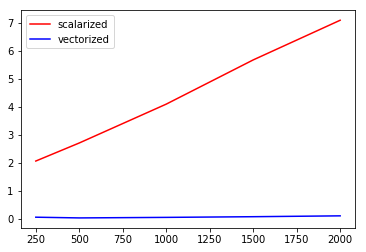

In [18]:
ms1 = [250, 500, 1000, 1500, 2000]
n = 250
ts1 = list()
tv1 = list()
for m in ms1:
    A, b, c = gen_A_b_c(m, n)
    p = vectorized_problem(A, b, c)
    tv1.append(compile_time(p))
    p = scalarized_problem(A, b, c)
    ts1.append(compile_time(p))

plt.plot(ms1, ts1, 'r', label='scalarized')
plt.plot(ms1, tv1, 'b', label='vectorized')
plt.legend(loc='upper left')

From the plot above, we see that the time needed for a fully vectorized model to compile is virtually constant, even as the number of constraints varies over an order of magnitude. The scalarized model is subtantially slower than the vectorized model (even when m=250), and it exhibits a clear linear trend in the runtime complexity.

It might be tempting to think that a linear trend in the number of constraints isn't a problem, and in some cases, it really isn't! However when practitioners solve larger and larger optimization problems, the number of variables tends to vary with the number of constraints. This coupling effectively means that when an engineer "linearly" increases the resolution of their optimization problem, cvxpy is actually handled problems that grow quadratically, if not worse. 

# Test 2: Vary n with m.

In the following test, we compare cvxpy compile times for vectorized and scalarized models when n varies with m. To keep the runtime of this test to a reasonable level, we fix n = 2 * m. Note that even with this choice, it takes a few minutes for the following cell to run on our machine.

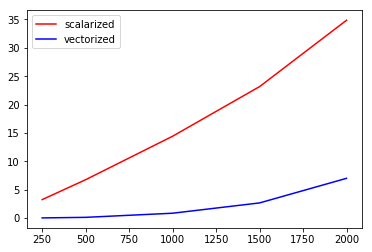

In [19]:
ms2 = [250, 500, 1000, 1500, 2000]
n_m_factor = 2
ts2 = list()
tv2 = list()
for m in ms2:
    A, b, c = gen_A_b_c(m, n=n_m_factor * m)
    p = vectorized_problem(A, b, c)
    tv2.append(compile_time(p, solver))
    p = scalarized_problem(A, b, c)
    ts2.append(compile_time(p, solver))
    
plt.plot(ms2, ts2, 'r', label='scalarized')
plt.plot(ms2, tv2, 'b', label='vectorized')
plt.legend(loc='upper left')

From the plot above we see that even the fully vectorized model exhibits a super-linear time complexity as the number of constraints increases. However, the extent to which this happens is tolerable for a variety of applications. The situation is different with the scalarized model; that model takes almost a full minute to handle the case with m=2000 and n=4000!

# Closing Remarks

We'd like to emphasize that these test cases are quite tame. The usefulness of cvxpy arises not from providing an interface for linear programming, but from providing an interface for a broad range of tractable convex programs. The work performed by cvxpy is to allow the user to provide natural input using these constructions, then transform that input for low level solvers with very rigid input requirements. The more complex these transformations are, the more the user benefits from specifying vectorized models. 

In fact, this notebook was written after a user working with the exponential cone (via the function kl_div) found that a *more* vectorized version of their model compiled in less than one second, while a *less* vectorized version of the same model took over 20 minutes to compile.